In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import shutil
from google.colab import files

Mounted at /content/drive/


In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from numpy.ma.core import ceil
from scipy.spatial import distance #distance calculation
from sklearn.preprocessing import MinMaxScaler #normalisation
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import animation, colors

In [ ]:
data_path = "/content/drive/MyDrive/Pressure Region of Interest"
array = []
for file in os.listdir(data_path):
    file_path = os.path.join(data_path, file)
    df = pd.read_csv(file_path, header = None)
    flatten_df = df.to_numpy().flatten()
    flatten_df = np.append(flatten_df, os.path.splitext(file)[0])
    array.append(flatten_df)

In [ ]:
pressure_df = pd.DataFrame(array)
pressure_df.rename(columns={225: "Name"}, inplace=True)
pressure_df


,0,1,2,3,4,5,6,7,8,9,...,216,217,218,219,220,221,222,223,224,Name
0,12414,12413,12408,12397,12381,12360,12341,12324,12313,12308,...,12348,12343,12343,12350,12363,12380,12402,12421,12439,3449_c9_cp2_29_58
1,12313,12316,12317,12314,12310,12305,12302,12300,12302,12305,...,12319,12314,12308,12304,12303,12305,12313,12322,12332,3450_c8_cp2_98_50
2,12379,12365,12352,12341,12332,12326,12324,12323,12317,12311,...,12362,12368,12377,12386,12397,12411,12424,12434,12441,3450_c8_cp3_59_56
3,12326,12330,12330,12330,12329,12325,12322,12320,12319,12317,...,12319,12321,12323,12325,12328,12334,12341,12352,12364,3451_c8_cp2_99_50
4,12437,12434,12431,12428,12427,12426,12425,12425,12426,12428,...,12431,12435,12444,12455,12465,12475,12483,12486,12494,3452_c8_cp3_55_59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,11938,11928,11919,11910,11902,11894,11888,11881,11874,11868,...,11968,11977,11987,11997,12009,12022,12038,12054,12070,1648_c3_cp2_15_28
3648,12510,12507,12510,12508,12505,12500,12496,12492,12488,12483,...,12452,12453,12453,12453,12458,12464,12473,12477,12483,1648_c9_cp3_65_62
3649,12443,12457,12466,12476,12480,12487,12488,12494,12490,12486,...,12492,12487,12478,12470,12468,12466,12466,12466,12464,1649_c11_cp1_61_51
3650,11833,11833,11833,11834,11834,11834,11833,11833,11834,11835,...,11862,11868,11877,11889,11904,11921,11941,11963,11987,1649_c3_cp2_16_25


In [ ]:
training_data_path = "/content/drive/MyDrive/First2YearRawAndNormData/CESMZ200/MinMaxNormWithLabel"
CL_path = training_data_path + "/CL"
COH_path = training_data_path + "/COH"
COL_path = training_data_path + "/COL"
NROI_path = training_data_path + "/NROI"


In [ ]:
CL_files = [f for f in os.listdir(CL_path) if f.endswith('.csv')]
COH_files = [f for f in os.listdir(COH_path) if f.endswith('.csv')]
COL_files = [f for f in os.listdir(COL_path) if f.endswith('.csv')]
NROI_files = [f for f in os.listdir(NROI_path) if f.endswith('.csv')]


In [ ]:
array = []
for file in CL_files:
    dataframe = pd.read_csv(os.path.join(CL_path, file), header=None)
    dataframe = dataframe.to_numpy().flatten()
    array.append(dataframe)

for file in COH_files:
    dataframe = pd.read_csv(os.path.join(COH_path, file), header=None)
    dataframe = dataframe.to_numpy().flatten()
    array.append(dataframe)

for file in COL_files:
    dataframe = pd.read_csv(os.path.join(COL_path, file), header=None)
    dataframe = dataframe.to_numpy().flatten()
    array.append(dataframe)

for file in NROI_files:
    dataframe = pd.read_csv(os.path.join(NROI_path, file), header=None)
    dataframe = dataframe.to_numpy().flatten()
    array.append(dataframe)


In [ ]:
training_df = array
training_df = pd.DataFrame(training_df)
training_df.info()
Y = []
for i in range(len(CL_files)):
  Y.append(0)

for i in range(len(COH_files)):
  Y.append(1)

for i in range(len(COL_files)):
  Y.append(2)

for i in range(len(NROI_files)):
  Y.append(3)

Y = pd.DataFrame(Y)

scaler = StandardScaler()
X = scaler.fit_transform(training_df)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Columns: 225 entries, 0 to 224
dtypes: float64(225)
memory usage: 1.3 MB


In [ ]:
#Normalization
def minmax_scaler(data):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)
    return scaled

#Euclidean distance
def e_distance(x, y):
    return distance.euclidean(x, y)

#Manhanttan distance
def m_distance(x, y):
    return distance.cityblock(x, y)

#Best Matching Unit search
def winning_neuron(data, t, som, num_rows, num_cols):
  winner = [0,0]
  shortest_distance = np.sqrt(data.shape[1]) # initialise with max distance
  input_data = data[t]
  for row in range(num_rows):
    for col in range(num_cols):
      distance = e_distance(som[row][col], data[t])
      if distance < shortest_distance:
        shortest_distance = distance
        winner = [row,col]
  return winner

#Learning rate and neighbourhood range calculation
def decay(step, max_steps,max_learning_rate,max_m_dsitance):
  coefficient = 1.0 - (np.float64(step)/max_steps)
  learning_rate = coefficient*max_learning_rate
  neighbourhood_range = ceil(coefficient * max_m_dsitance)
  return learning_rate, neighbourhood_range


In [ ]:
num_rows = 15
num_cols = 15
max_m_dsitance = 10
max_learning_rate = 0.75
max_steps = 100000

In [ ]:
#main function

train_x_norm = minmax_scaler(X) # normalisation
# initialising self-organising map
num_dims = train_x_norm.shape[1] # numnber of dimensions in the input data
#np.random.seed(40)
som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction

# start training iterations
for step in range(max_steps):
  if (step+1) % 1000 == 0:
    print("Iteration: ", step+1) # print out the current iteration for every 1k
  learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_dsitance)

  t = np.random.randint(0,high=train_x_norm.shape[0]) # random index of traing data
  winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
  for row in range(num_rows):
    for col in range(num_cols):
      if m_distance([row,col],winner) <= neighbourhood_range:
        som[row][col] += learning_rate*(train_x_norm[t]-som[row][col]) #update neighbour's weight

print("SOM training completed")

Iteration:  1000
Iteration:  2000
Iteration:  3000
Iteration:  4000
Iteration:  5000
Iteration:  6000
Iteration:  7000
Iteration:  8000
Iteration:  9000
Iteration:  10000
Iteration:  11000
Iteration:  12000
Iteration:  13000
Iteration:  14000
Iteration:  15000
Iteration:  16000
Iteration:  17000
Iteration:  18000
Iteration:  19000
Iteration:  20000
Iteration:  21000
Iteration:  22000
Iteration:  23000
Iteration:  24000
Iteration:  25000
Iteration:  26000
Iteration:  27000
Iteration:  28000
Iteration:  29000
Iteration:  30000
Iteration:  31000
Iteration:  32000
Iteration:  33000
Iteration:  34000
Iteration:  35000
Iteration:  36000
Iteration:  37000
Iteration:  38000
Iteration:  39000
Iteration:  40000
Iteration:  41000
Iteration:  42000
Iteration:  43000
Iteration:  44000
Iteration:  45000
Iteration:  46000
Iteration:  47000
Iteration:  48000
Iteration:  49000
Iteration:  50000
Iteration:  51000
Iteration:  52000
Iteration:  53000
Iteration:  54000
Iteration:  55000
Iteration:  56000
I

In [ ]:
label_data = np.array(Y)
map = np.empty(shape=(num_rows, num_cols), dtype=object)

for row in range(num_rows):
  for col in range(num_cols):
    map[row][col] = [] # empty list to store the label

for t in range(train_x_norm.shape[0]):
  if (t+1) % 1000 == 0:
    print("sample data: ", t+1)
  winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
  map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron

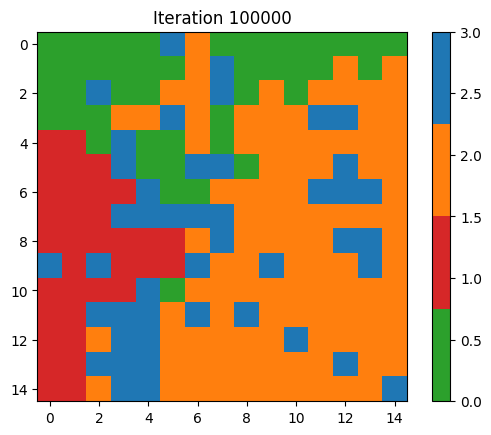

In [ ]:
# construct label map
label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
for row in range(num_rows):
  for col in range(num_cols):
    label_list = map[row][col]
    if len(label_list)==0:
      label = 3
    else:
      label = max(label_list, key=label_list.count)
    label_map[row][col] = label

title = ('Iteration ' + str(max_steps))
cmap = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange', 'tab:blue'])
plt.imshow(label_map, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()

In [ ]:
df = pressure_df.drop("Name", axis = 1)

In [ ]:
data = minmax_scaler(df)

winner_labels = []

for t in range(data.shape[0]):
  winner = winning_neuron(data, t, som, num_rows, num_cols)
  row = winner[0]
  col = winner[1]
  predicted = label_map[row][col]
  winner_labels.append(predicted)



In [ ]:
pressure_df["Class"] = winner_labels
pressure_df

,0,1,2,3,4,5,6,7,8,9,...,217,218,219,220,221,222,223,224,Name,Class
0,12414,12413,12408,12397,12381,12360,12341,12324,12313,12308,...,12343,12343,12350,12363,12380,12402,12421,12439,3449_c9_cp2_29_58,2
1,12313,12316,12317,12314,12310,12305,12302,12300,12302,12305,...,12314,12308,12304,12303,12305,12313,12322,12332,3450_c8_cp2_98_50,3
2,12379,12365,12352,12341,12332,12326,12324,12323,12317,12311,...,12368,12377,12386,12397,12411,12424,12434,12441,3450_c8_cp3_59_56,2
3,12326,12330,12330,12330,12329,12325,12322,12320,12319,12317,...,12321,12323,12325,12328,12334,12341,12352,12364,3451_c8_cp2_99_50,3
4,12437,12434,12431,12428,12427,12426,12425,12425,12426,12428,...,12435,12444,12455,12465,12475,12483,12486,12494,3452_c8_cp3_55_59,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,11938,11928,11919,11910,11902,11894,11888,11881,11874,11868,...,11977,11987,11997,12009,12022,12038,12054,12070,1648_c3_cp2_15_28,2
3648,12510,12507,12510,12508,12505,12500,12496,12492,12488,12483,...,12453,12453,12453,12458,12464,12473,12477,12483,1648_c9_cp3_65_62,2
3649,12443,12457,12466,12476,12480,12487,12488,12494,12490,12486,...,12487,12478,12470,12468,12466,12466,12466,12464,1649_c11_cp1_61_51,3
3650,11833,11833,11833,11834,11834,11834,11833,11833,11834,11835,...,11868,11877,11889,11904,11921,11941,11963,11987,1649_c3_cp2_16_25,2


In [ ]:
ROI = {}
data = pressure_df.to_numpy()
for item in data:
    part = item[225].split("_")
    day = int(part[0])
    x = int(part[3])
    y = int(part[4])
    category = item[226]
    if day in ROI:
        ROI[day].append([x, y, category])
    else:
        ROI[day] = [[x, y, category]]



In [ ]:
folder_name = "Categorical_ROI_Pressure_Image"
folder_path = "/content/drive/MyDrive/" + folder_name

os.makedirs(folder_path)

In [ ]:
image_path = "/content/drive/MyDrive/Pressure_raw_Image"
color_list = {0: (0, 255, 0), 1: (0, 0, 255), 2: (0, 255, 255), 3: (255, 0, 0)}
for file in os.listdir(image_path):
    file_path = os.path.join(image_path, file)
    final_img = cv2.imread(file_path)

    file_name = os.path.splitext(file)[0]
    number = int(file_name[3:])

    if number in ROI:
        for point in ROI[number]:
            x = point[0]
            y = point[1]
            color = color_list[point[2]]

            size = 2

            vertices = np.array([(x, y - size), (x - size, y), (x, y + size), (x + size, y)])

            cv2.drawContours(final_img, [vertices.reshape((-1, 1, 2))], -1, color, thickness = cv2.FILLED)

        cv2.imwrite(folder_path + "/day" + str(number) + ".png", final_img)